In [23]:
# Directory

!pwd

/home/ec2-user/SageMaker


In [26]:
# Confirm sagemaker role exists

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session

role = get_execution_role()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='arn:aws:iam::971504885040:role/SageMaker')['Role']['Arn']

In [27]:
# Import files from S3

import pandas as pd
import boto3
import io

bucket = "sagemaker-w210-eth"

# Txt file
data_key = '2021-09-01/transaction_hashes_13136427_13142881.txt'
s3_client = boto3.client('s3')
obj = s3_client.get_object(Bucket=bucket, Key=data_key)
contents = obj['Body'].read()
print(contents.decode("utf-8"))

# CSV file
# file_key = '2021-09-01/tokens_13136427_13142881.csv'
# s3_client = boto3.client('s3')
# obj = s3_client.get_object(Bucket=bucket, Key=file_key)
# df = pd.read_csv(io.BytesIO(obj['Body'].read()))
# df.head()

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import intersect1d
from datetime import datetime
from pyathena import connect

In [3]:
from ethereum import (
    timestamp_to_datetime,
    EthereumData
)
from utils import (
    latest,
    lead_lag,
    add_latest_avail_block,
    lagged_block_data
)

In [4]:
conn = connect(
    s3_staging_dir='s3://sagemaker-w210-eth/raw_data/August/',
    region_name='us-west-2'
)

In [5]:
conn.close()

In [6]:
cols = [
    'number', 'difficulty', 'total_difficulty', 'size', 'gas_limit', 
    'gas_used', 'timestamp', 'transaction_count', 'base_fee_per_gas'
]

blocks = pd.read_sql(f"SELECT {', '.join(cols)} FROM ethereumetl.blocks", conn)
blocks.shape

(174710, 9)

In [7]:
blocks.head()

,number,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas
0,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN
1,12962018.0,None,None,55433.0,15000000.0,14994306.0,1.628126e+09,160.0,NaN
2,12962019.0,None,None,79403.0,14985353.0,14969945.0,1.628126e+09,217.0,NaN
3,12962020.0,None,None,69949.0,14970720.0,14964505.0,1.628126e+09,155.0,NaN
4,12962021.0,None,None,92704.0,14956102.0,14944125.0,1.628126e+09,195.0,NaN


In [1]:
import numpy as np
import pandas as pd

import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor    
# from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
print("OK")

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics

from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from xgboost import plot_importance

OK


## Load Data

In [2]:
data = pd.read_csv(r'C:\Users\rol\Desktop\w210\merged_df.csv')

In [3]:
data.head()

,Unnamed: 0,datetime,lag_cutoff,latest_avail_block,timestamp,difficulty,total_difficulty,size,gas_limit,gas_used_x,...,gas,gas_price,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,transaction_hash,cumulative_gas_used,gas_used_y,status,effective_gas_price
0,0,2021-09-01 00:00:12,2021-08-31 23:59:12,NaN,1630454412,8409848555241209,29853078656530319963926,160051,30029266,30015153,...,300000.0,1.243733e+11,NaN,NaN,0.0,0xdf1540c9bb3e44dc41e35603046bbffd67171b31399e...,164019.0,164019.0,1.0,1.243733e+11
1,1,2021-09-01 00:00:12,2021-08-31 23:59:12,NaN,1630454412,8409848555241209,29853078656530319963926,160051,30029266,30015153,...,265742.0,1.242028e+11,3.497839e+11,0.000000e+00,2.0,0x35c8854601809a98bbdb0ef84ae8def378962f5b609c...,390486.0,226467.0,1.0,1.242028e+11
2,2,2021-09-01 00:00:12,2021-08-31 23:59:12,NaN,1630454412,8409848555241209,29853078656530319963926,160051,30029266,30015153,...,250000.0,3.490306e+11,NaN,NaN,0.0,0xa702f078b50ef377bd165f21d28e7238acca741f74e3...,496355.0,105869.0,1.0,3.490306e+11
3,3,2021-09-01 00:00:12,2021-08-31 23:59:12,NaN,1630454412,8409848555241209,29853078656530319963926,160051,30029266,30015153,...,286357.0,1.262028e+11,1.998429e+11,2.000000e+09,2.0,0xf32ecb8b499256a8ca64c5ab023db661ae505a87e671...,682268.0,185913.0,1.0,1.262028e+11
4,4,2021-09-01 00:00:12,2021-08-31 23:59:12,NaN,1630454412,8409848555241209,29853078656530319963926,160051,30029266,30015153,...,238807.0,1.447516e+11,1.447516e+11,1.447516e+11,2.0,0x0a591170911e195c5ef139bcc0a78fc42e268e7e3212...,836485.0,154217.0,1.0,1.447516e+11


In [4]:
print("min block number:", data.block_number.min())
print("median block number:", data.block_number.median())
print("max block number:", data.block_number.max())

min block number: 13136427
median block number: 13139616.0
max block number: 13142881


In [5]:
print("length of data before dropping NAs:", len(data))
data = data.dropna()
print("length of data after dropping NAs:", len(data))

length of data before dropping NAs: 1225214
length of data after dropping NAs: 629154


## Create train / dev / test splits

In [14]:

X_columns = ['difficulty_mean_5_lagged', 'size_mean_5_lagged', 'gas_limit_mean_5_lagged', 
                    'base_fee_per_gas_mean_5_lagged']

Y_column = ['effective_gas_price']

# X_train = data[data.timestamp<'10/01/2021'][X_columns]
# Y_train = data[data.timestamp<'10/01/2021'][Y_column]

# X_dev = data[(data.timestamp>='10/01/2021') & (data.timestamp<='11/01/2021')][X_columns]
# Y_dev = data[(data.timestamp>='10/01/2021') & (data.timestamp<='11/01/2021')][Y_column]

# X_test = data[data.timestamp>'11/01/2021'][X_columns]
# Y_test = data[data.timestamp>'11/01/2021'][Y_column]

X_train = data[data.block_number<13141000][X_columns]
Y_train = data[data.block_number<13141000][Y_column]

X_dev = data[(data.block_number>=13141000) & (data.block_number<=13141000)][X_columns]
Y_dev = data[(data.block_number>=13141000) & (data.block_number<=13141000)][Y_column]

X_test = data[data.block_number>13143000][X_columns]
Y_test = data[data.block_number>13143000][Y_column]

#create data sets that concatenates X's and y's for EDA
train_data = X_train.copy()
dev_data = X_dev.copy()
test_data = X_test.copy()

In [13]:
data.columns

Index(['Unnamed: 0', 'datetime', 'lag_cutoff', 'latest_avail_block',
       'timestamp', 'difficulty', 'total_difficulty', 'size', 'gas_limit',
       'gas_used_x', 'transaction_count', 'base_fee_per_gas',
       'timestamp_mean_5_lagged', 'difficulty_mean_5_lagged',
       'total_difficulty_mean_5_lagged', 'size_mean_5_lagged',
       'gas_limit_mean_5_lagged', 'gas_used_mean_5_lagged',
       'transaction_count_mean_5_lagged', 'base_fee_per_gas_mean_5_lagged',
       'hash', 'block_number', 'gas', 'gas_price', 'max_fee_per_gas',
       'max_priority_fee_per_gas', 'transaction_type', 'transaction_hash',
       'cumulative_gas_used', 'gas_used_y', 'status', 'effective_gas_price'],
      dtype='object')

## Linear Regression

In [15]:
# Call in the LinearRegression object
lin_reg = LinearRegression(normalize=True, n_jobs=-1)

lin_reg_features = ['difficulty_mean_5_lagged', 'size_mean_5_lagged', 'gas_limit_mean_5_lagged', 
                    'base_fee_per_gas_mean_5_lagged']


# fit train and test data. 
lin_reg.fit(X_train[lin_reg_features], Y_train)

# Predict train data. 
y_train_pred = lin_reg.predict(X_train[lin_reg_features])

# Get training metrics
lr_mse_train = mean_squared_error(Y_train, y_train_pred)
lr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
lr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

print ('The MSE of the Linear Regression model on train data is: %.4f'%lr_mse_train)
print ('The RMSE of the Linear Regression model on train data is: %.4f'%lr_rmse_train)
print ('The R^2 of the Linear Regression model on train data is: %.4f'%lr_r2score_train)

# Predict dev data. 
y_dev_pred_lr = lin_reg.predict(X_dev[lin_reg_features])

lr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_lr)
lr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_lr))
lr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_lr)

print ('The MSE of the Linear Regression model on dev data is: %.4f'%lr_mse_dev)
print ('The RMSE of the Linear Regression model on dev data is: %.4f'%lr_rmse_dev)
print ('The R^2 of the Linear Regression model on dev data is: %.4f'%lr_r2score_dev)

lin_reg.coef_

The MSE of the Linear Regression model on train data is: 13619172329015994220544.0000
The RMSE of the Linear Regression model on train data is: 116701209629.6178
The R^2 of the Linear Regression model on train data is: 0.0960
The MSE of the Linear Regression model on dev data is: 914342224284898295808.0000
The RMSE of the Linear Regression model on dev data is: 30238092272.5773
The R^2 of the Linear Regression model on dev data is: -0.0032


array([[-1.41536299e-05,  8.50360425e+04, -1.43444418e+04,
         9.66423484e-01]])

In [16]:
import statsmodels.api as sm
mod = sm.OLS(Y_train,X_train[lin_reg_features])
mod2 = mod.fit()
print(mod2.summary())

                             OLS Regression Results                            
Dep. Variable:     effective_gas_price   R-squared:                       0.096
Model:                             OLS   Adj. R-squared:                  0.096
Method:                  Least Squares   F-statistic:                 1.571e+04
Date:                 Wed, 20 Oct 2021   Prob (F-statistic):               0.00
Time:                         09:54:41   Log-Likelihood:            -1.1945e+07
No. Observations:               444015   AIC:                         2.389e+07
Df Residuals:                   444011   BIC:                         2.389e+07
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
di

## Ridge Regression

In [17]:
#Instantiate regression
ridge_reg = Ridge(alpha=0.75, random_state=42)

# fit train and test data. 
ridge_reg.fit(X_train[lin_reg_features], Y_train)

# Predict train data. 
y_train_pred_rr = ridge_reg.predict(X_train[lin_reg_features])

# Get training metrics
rr_mse_train = mean_squared_error(Y_train, y_train_pred)
rr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
rr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

print ('The MSE of the Ridge Regression model on train data is: %.4f'%rr_mse_train)
print ('The RMSE of the Ridge Regression model on train data is: %.4f'%rr_rmse_train)
print ('The R^2 of the Ridge Regression model on train data is: %.4f'%rr_r2score_train)

# Predict dev data. 
y_dev_pred_rr = ridge_reg.predict(X_dev[lin_reg_features])

rr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_rr)
rr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_rr))
rr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_rr)

print ('The MSE of the Ridge Regression model on dev data is: %.4f'%lr_mse_dev)
print ('The RMSE of the Ridge Regression model on dev data is: %.4f'%lr_rmse_dev)
print ('The R^2 of the Ridge Regression model on dev data is: %.4f'%lr_r2score_dev)

print("coefficients:", ridge_reg.coef_)

The MSE of the Ridge Regression model on train data is: 13619172329015994220544.0000
The RMSE of the Ridge Regression model on train data is: 116701209629.6178
The R^2 of the Ridge Regression model on train data is: 0.0960
The MSE of the Ridge Regression model on dev data is: 914342224284898295808.0000
The RMSE of the Ridge Regression model on dev data is: 30238092272.5773
The R^2 of the Ridge Regression model on dev data is: -0.0032
coefficients: [[-1.41536299e-05  8.50360425e+04 -1.43444418e+04  9.66423484e-01]]


## Random Forest

In [19]:
#Instantiate the random forest
rf = RandomForestRegressor(n_estimators = 1000, max_depth = 3, bootstrap = True, max_features = 4, 
                           min_samples_leaf = 50, random_state = 42)

rf_features = ['difficulty_mean_5_lagged', 'size_mean_5_lagged', 'gas_limit_mean_5_lagged', 
                    'base_fee_per_gas_mean_5_lagged']

#Train the model on the training data
rf.fit(X_train[rf_features], Y_train)

#Get the predictions on the training data set
rf_train_predictions = rf.predict(X_train[rf_features])

#Get the predictions on the dev data set
rf_dev_predictions = rf.predict(X_dev[rf_features])


rf_MSE_train = mean_squared_error(Y_train, rf_train_predictions)
rf_MSE_dev = mean_squared_error(Y_dev, rf_dev_predictions)
print(rf_MSE_train)
print(rf_MSE_dev)

1.3583380527214555e+22
9.117129486307909e+20


                         Features  Feature_Importance
3  base_fee_per_gas_mean_5_lagged             0.97553
1              size_mean_5_lagged             0.02447
0        difficulty_mean_5_lagged             0.00000
2         gas_limit_mean_5_lagged             0.00000


<AxesSubplot:title={'center':'Random Forest Feature Importance'}, ylabel='Features'>

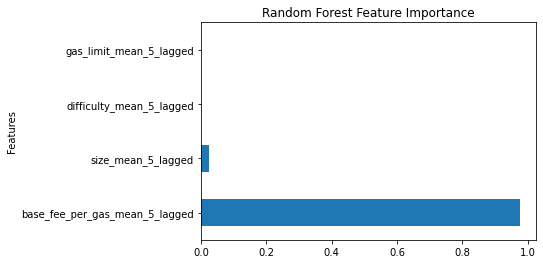

In [20]:
rf_feature_importances = rf.feature_importances_
rf_feature_importances_dict = {'Features': rf_features,
                               'Feature_Importance': rf_feature_importances}
rf_feature_importances_df = pd.DataFrame(rf_feature_importances_dict)
rf_feature_importances_df.sort_values(by=['Feature_Importance'], 
                                      ascending=False,
                                      inplace=True)
print(rf_feature_importances_df.head(30))

rf_feature_importances_df = rf_feature_importances_df.set_index('Features')
rf_feature_importances_df['Feature_Importance'].nlargest(15).plot(kind='barh',
                                                                  title='Random Forest Feature Importance')

In [ ]:
data.columns

## Gradient Boosting

In [21]:
xgb_features = ['difficulty_mean_5_lagged', 'size_mean_5_lagged', 'gas_limit_mean_5_lagged', 
                    'base_fee_per_gas_mean_5_lagged']

#set up the training matrix
dtrain = xgb.DMatrix(X_train[xgb_features], label=Y_train)
xgb_dict = {
        'booster': 'dart',
        #'booster': 'gbtree',
        #'booster': 'gblinear',
        'max_depth': 3,
        'random_state': 42,
        'learning_rate': 0.01,
        'objective': 'reg:squarederror',
        'verbosity': 0,
        'sample_type': 'uniform',
        'subsample': 0.6,
        'normalize_type': 'tree',
        'rate_drop': 0.0,
        #'rate_drop': 0.2,
        'skip_drop': 0.2,
        'min_child_weight': 5,
        
    }
#starting hyperparameter of training rounds
training_rounds = 500

#train the model
bst = xgb.train(
    xgb_dict,
    dtrain,
    training_rounds,
    evals=[(xgb.DMatrix(X_dev[xgb_features], label=Y_dev), 'RMSE')],
    early_stopping_rounds=10) 


training_rounds = bst.best_ntree_limit
 
#get training predictions and MSE
xgb_train_pred = bst.predict(xgb.DMatrix(X_train[xgb_features]), ntree_limit=training_rounds)
xgb_train_mse = mean_squared_error(xgb_train_pred, Y_train)
xgb_train_rmse = np.sqrt(xgb_train_mse)

#print("XGB train mean squared error:", xgb_train_mse)
print("XGB train root mean squared error:", xgb_train_rmse)

#get dev predictions and MSE
xgb_dev_pred = bst.predict(xgb.DMatrix(X_dev[xgb_features]), ntree_limit=training_rounds)
xgb_dev_mse = mean_squared_error(xgb_dev_pred, Y_dev)
xgb_dev_rmse = np.sqrt(xgb_dev_mse)

#print("XGB dev mean squared error:", xgb_dev_mse)
print("XGB dev root mean squared error:", xgb_dev_rmse)

[0]	RMSE-rmse:1.83719e+11
Will train until RMSE-rmse hasn't improved in 10 rounds.
[1]	RMSE-rmse:1.81964e+11
[2]	RMSE-rmse:1.80101e+11
[3]	RMSE-rmse:1.78351e+11
[4]	RMSE-rmse:1.76683e+11
[5]	RMSE-rmse:1.7499e+11
[6]	RMSE-rmse:1.73323e+11
[7]	RMSE-rmse:1.71706e+11
[8]	RMSE-rmse:1.69949e+11
[9]	RMSE-rmse:1.68334e+11
[10]	RMSE-rmse:1.66767e+11
[11]	RMSE-rmse:1.64936e+11
[12]	RMSE-rmse:1.63249e+11
[13]	RMSE-rmse:1.61591e+11
[14]	RMSE-rmse:1.60085e+11
[15]	RMSE-rmse:1.58483e+11
[16]	RMSE-rmse:1.56981e+11
[17]	RMSE-rmse:1.55253e+11
[18]	RMSE-rmse:1.5367e+11
[19]	RMSE-rmse:1.52245e+11
[20]	RMSE-rmse:1.50836e+11
[21]	RMSE-rmse:1.49379e+11
[22]	RMSE-rmse:1.48004e+11
[23]	RMSE-rmse:1.46387e+11
[24]	RMSE-rmse:1.44908e+11
[25]	RMSE-rmse:1.43561e+11
[26]	RMSE-rmse:1.41992e+11
[27]	RMSE-rmse:1.4034e+11
[28]	RMSE-rmse:1.38822e+11
[29]	RMSE-rmse:1.37296e+11
[30]	RMSE-rmse:1.35905e+11
[31]	RMSE-rmse:1.34649e+11
[32]	RMSE-rmse:1.33385e+11
[33]	RMSE-rmse:1.32036e+11
[34]	RMSE-rmse:1.30818e+11
[35]	RMSE-r

In [22]:
#feature importance
xgb_importance_weight = bst.get_score(importance_type='weight')
xgb_importance_gain = bst.get_score(importance_type='gain')
xgb_importance_weight_df = pd.DataFrame.from_dict(xgb_importance_weight,
                                                  orient='index',
                                                  columns=['weight'])
xgb_importance_gain_df = pd.DataFrame.from_dict(xgb_importance_gain,
                                                  orient='index',
                                                  columns=['gain'])
xgb_feature_importance_df = xgb_importance_weight_df.join(xgb_importance_gain_df)
xgb_feature_importance_df.sort_values(by=['weight'], ascending=False, inplace=True)                 
print(xgb_feature_importance_df.head(30))


                                weight          gain
base_fee_per_gas_mean_5_lagged    1240  1.619381e+25
difficulty_mean_5_lagged           725  1.133724e+24
size_mean_5_lagged                 571  2.749343e+24
gas_limit_mean_5_lagged            185  1.085823e+24


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

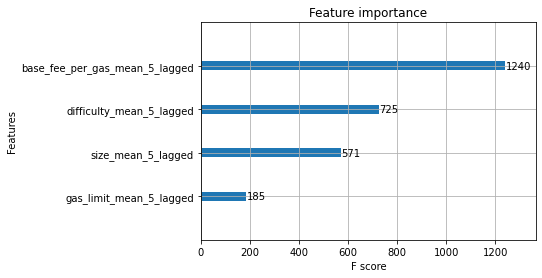

In [23]:
plot_importance(bst, max_num_features=30)

## Ensemble

In [48]:
ensemble_train_preds = (y_train_pred.ravel() + y_train_pred_rr.ravel() + rf_train_predictions + xgb_train_pred) / 4
print("train_rmse =", np.sqrt(mean_squared_error(ensemble_train_preds, Y_train)))


train_rmse = 116442247805.48709


In [28]:
len(y_train_pred)

444015

In [34]:
len(xgb_train_pred)

444015

In [44]:
type(y_train_pred_rr)

numpy.ndarray

In [38]:
a = np.array([1,2,3])
b = np.array([4,5,6])
c = (a + b)/2
c

array([2.5, 3.5, 4.5])

In [46]:
y_train_pred.ravel().shape

(444015,)